In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
from jax.scipy.special import expit
from jax import random
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import arviz as az

DATA_PATH = "../data/Causality_tDCS_sample.csv"
rng_key = random.key(1133555)

## 1. Load and inspect the data

We first need to get an overview of our data and understand what each variable means. Before continuing though, you should first get an overview of the experiment, understand the task and the procedure. You can find a very brief summary here and have a look at one of the papers for more details.

**Experiment summary**

Participants were observing simulated Michotte Launching Events where a blue disk moves towards a red one, comes into contact with it, stops and then the red one starts moving. They gave binary judgements whether they perceived the event as causal or non-causal. <br>
Participants either belonged to a ``group`` of patients being treated for Schizophrenia Spectrum Disorder (SSD) or a healthy control (HC) group. <br>
In each trial the red disk moved with a certain ``angle`` of egress and a certain ``delay`` after the contact. <br>
Each participant repeated the same 98 trials on different days. They did 48 trials first, then a transcranial direct current stimulation (tDCS) was applied, then they did the same 48 trials again. On each day the stimulation was applied to a different brain area. HCs took part in 7 different ``stimulation``s, SSDs only in 4 different stimulations. <br>
Foreach trial the given `causality_judgement` and the response time (`RT`) was collected.

Related papers for more details and figures:

* Streiling, K., Schülke, R., Straube, B. et al. Choice- and trial-history effects on causality perception in Schizophrenia Spectrum Disorder. Schizophr 11, 65 (2025). https://doi.org/10.1038/s41537-025-00614-0
* Schülke R, Schmitter CV, Straube B. Improving causality perception judgments in schizophrenia spectrum disorder via transcranial direct current stimulation. J Psychiatry Neurosci. 2023 Jul 4;48(4):E245-E254. doi: https://10.1503/jpn.220184. Erratum in: J Psychiatry Neurosci. 2024 Apr 23;49(2):E144. doi: 10.1503/jpn.240042. PMID: 37402578; PMCID: PMC10322162.

In [2]:
# read in data
df = pd.read_csv(DATA_PATH, sep="\t")
df

,subject_id,selection_matching,baseline_stimulation,stimulation,group,time,angle,causality_judgement,RT,trialnumber,RT_corrected_for_delay,error_responses
0,2.0,1,1.0,1.0,0.0,4.0,"22,5",1.0,"1557,1",1.0,"1490,46",0
1,2.0,1,1.0,1.0,0.0,0.0,30,1.0,"1480,6",2.0,"1480,6",0
2,2.0,1,1.0,1.0,0.0,16.0,"22,5",0.0,1615,3.0,"1348,44",0
3,2.0,1,1.0,1.0,0.0,0.0,0,1.0,"1395,2",4.0,"1395,2",0
4,2.0,1,1.0,1.0,0.0,8.0,"22,5",0.0,"1530,4",5.0,"1397,12",0
...,...,...,...,...,...,...,...,...,...,...,...,...
53989,120.0,1,2.0,7.0,1.0,16.0,45,0.0,"1930,9",95.0,"1664,34",0
53990,120.0,1,2.0,7.0,1.0,6.0,0,1.0,"1706,4",96.0,"1606,44",0
53991,120.0,1,2.0,7.0,1.0,4.0,0,1.0,"1720,5",97.0,"1653,86",0
53992,120.0,1,2.0,7.0,1.0,2.0,"22,5",1.0,"1719,9",98.0,"1686,58",0


**Data columns**

* `subject_id`: The ID of each participant. IDs below 100 belong to HCs.
* `selection_matching`: There were more HCs than SSDs. This column selects a subet of th HCs (`selection_match=1`) to make both groups demographically comparable
* `baseline_stimulation`: 1: trial was before the tDCS stimulation, 2: trial was after the stimulation
* `stimulation`: Type of stimulation applied
  * 1=LFC-RFA, 2=LFA-RFC, 3=LPC-RPA, 4=LPA-RPC, 5=LFC-RPA, 6=LFA-RPC, 7=sham 
  * where LFC = left frontal cathode, RFA=right frontal anode, LPC=left parietal cathode, etc.
* ``group``: 0: healthy control group, 1: patients with SSD
* ``time``: delay in frames between the contact of the blue ball and the start of the movement of the red
* `angle`: angle of egress (in degree) of the red ball's movement relative to the blue balls movement
* `causality_judgement`: 0: causal, 1: non causal
* `RT`: reaction time
* `trial number`: trial sequence identifier
* `RT_corrected_for_delay`: reaction time but corrected for the delay (value in `time`) of the trial
* `error_responses`: 0: valid response, 1: erroneous response, e.g. multiple answers were given. 

## 2. Model definition

We can now pose a question about this data, for example: 

                Do delay and angle influence the causality judgement differently for SSDs and HCs?              

#### Putting the Generalized into Linear Models
To answer this question with the data, we can make apply a range of ANOVAs, t-tests or Wilcoxon signed rank tests. An alternative is perform a sort of regression and see how the values of our variables (angle, time and group) influence the binary decision (causality_judgement). This sort of regression is called a *Generalized Model*. For starters, and because we have no other prior expectations, we can siimply assume a linear relation between angle and time, which makes the model a *Generalized Linear Model*.

The generalization comes from the fact that our dependent variable is binary, thus, we need a link function to link a real value (-$\infty$ to $+\infty$) to a value between 0 and 1 that we can interpret as the probability of one kind of response, e.g. the probability of responding "causal". Typically, we use the [logistic (or sigmoid or expit) function](https://en.wikipedia.org/wiki/Logistic_function) as link function:

$$p(x) = \frac{1}{1+e^{-x}}$$

where
* $x$ is the (linear) combination of our independent variables
* $p$ is the probability of responding "causal"

#### A lot of choices

The one challenge with any sort of (statistical) modelling is, that there is no single (statistical) model to rule the all. Here, for example, we have many choices how to combine our three variables (angle, time and group). 

**Starting somewhere** <br>
The naive and simplest way would be to assign each variable a *weight* and combine them linearly to get our input ($x$) to the logistic function above:

$$x_t = \alpha \cdot angle_t + \beta \cdot time_t + \gamma \cdot group_t$$

where 
* $x_t$ is the logit (input to the logistic function) at trial $t$
* $angle_t$, $time_t$, $group_t$ are the values of the three variables at trial $t$
* $\alpha$, $\beta$, $\gamma$ are the weights assign to the respective variable

**Remembering the question** <br>
If we look back to our question above however, we remember that we were actually interested in the *interaction* between the group and the effects of angle and time. <br>
To include this interaction we could, for example, add a group specific offset to the angle and time weights:

$$x_t = (\alpha + \alpha_g \cdot group) \cdot angle_t + (\beta + \beta_g \cdot group) \cdot time_t + \gamma \cdot group_t$$

where
* $\alpha_g$ is added to the weight of the angle ($\alpha$) depending on the value of group. <br> 
    To make the example clearer, we have mainly two ways of encoding the groups (HCs and SSD), that also slightly change the meaning of the weights:
  * If our group encodes HCs as 0 and SSDs as 1, then $\alpha_g$ is added to $\alpha$ if the participant is of the group SSD.
  * If our group encodes HCs as -1 and SSDs as 1, then $\alpha_g$ is added to $\alpha$ if the participant is of the group SSD and subtracted from $\alpha$ if the participant is of the group HC.

The equivalent explanation holds for the weight $\beta$.

Now, with that we have already defined two models and can now implement them in our favourite probabilistic programmin framework and compare them.

## 3. Data pre-processing

In order to do the fitting, we have to prepare our data a little bit.

First, we select the subset of healthy controls marked by the `selection_matching` column.

In [3]:
df = df[df["selection_matching"] == "1"]
# drop the column as it has no more information
df = df.drop(columns=["selection_matching"])

Then, in order to balance the two datasets, we only and keep data from those tDCS stimulation sessions that were conducted on both groups (session 1, 3, 5 and 7).

In [4]:
df = df[df["stimulation"].isin([1,3,5,7])]

Then we drop those trials that were marked as potentially erroneous.

In [5]:
df = df[df["error_responses"] == 0]
# drop the column as it has no more information
df = df.drop(columns=["error_responses"])

It seems that there is still one "weird" trial with a causality_judgement of 3...

In [6]:
df["causality_judgement"].value_counts()

causality_judgement
0.0    16172
1.0    15043
3.0        1
Name: count, dtype: int64

... so we drop this one too.

In [7]:
df = df[df["causality_judgement"].isin([0,1])]

Finally, our data is still not very clean. I.e. the angle and reaction time values are actually strings with the decimal sign being a German "," instead of a ".".
We can see this when we look at the DataFrame's dtypes:

In [8]:
df.dtypes

subject_id                float64
baseline_stimulation      float64
stimulation               float64
group                     float64
time                      float64
angle                      object
causality_judgement       float64
RT                         object
trialnumber               float64
RT_corrected_for_delay     object
dtype: object

So, we replace the decimal sign in these columns and convert them to floating point numbers:

In [9]:
for col in ["angle", "RT", "RT_corrected_for_delay"]:
    df[col] = list(map(lambda x: x.replace(",", "."), df[col]))
    df[col] = df[col].astype(float)

**Normalization**

Now, one trick to make these models find a solution quicker is to scale your data (or "normalize" it), i.e. compress it to a space somewhat close to zero in a meaningful way. <br>
We are left with only 4 columns containing real valued numbers: time, angle, RT and RT_corrected_for_delay. (The rest are categorical or binary).

Time and angle are not smaller than zero, so it makes sense to compress them to a range between 0 and 1 where 0 corresponds to the smallest and 1 to the largest value in our data (also called min-max normalization):

In [10]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

for col in ["time", "angle"]:
    df[col + "_norm"] = normalize(df[col])

The reaction time on the other hand looks at least somewhat Gaussian distributed (even if we have huge tail due to some very long outliers), so here we can standardize it with mean zero and standard deviation 1.

In [11]:
def standardize(x):
    return (x - x.mean()) / x.std()

for col in ["RT", "RT_corrected_for_delay"]:
    df[col + "_norm"] = standardize(df[col])

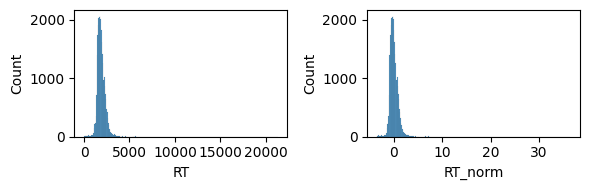

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

for i, col in enumerate(["RT", "RT_norm"]):
    sns.histplot(df, x=col, ax=axs[i])

plt.tight_layout()
plt.show()

## 4. Model implementation and fitting

As an example, we will use the frameworks [jax](https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html) and [numpyro](https://num.pyro.ai/en/stable/getting_started.html) here. Valid alternatives are [pymc](https://www.pymc.io/welcome.html) (similar interface) or [bambi](https://bambinos.github.io/bambi/) (very simple model definition uses pymc).

In [28]:
# Hint: Before we fit a model, we need to make sure our dataset does not contain missing values!
assert (df.isna().sum() == 0).all()

In [17]:
def model_baseline(angle, time, group, choice=None):
    # define prior distributions of weights
    alpha = npr.sample("alpha", dist.Normal(0, 1))
    beta = npr.sample("beta", dist.Normal(0, 1))
    gamma = npr.sample("gamma", dist.Normal(0, 1))

    logits = alpha * angle + beta * time + gamma * group

    if choice is None:
        # inspired by this numpyro example: https://num.pyro.ai/en/stable/examples/ucbadmit.html
        probs = expit(logits)
        npr.sample("probs", dist.Delta(probs), obs=probs)
    npr.sample("choice", dist.Bernoulli(logits=logits), obs=choice)
    # could alternatively do
    # probs = npr.deterministic("probs", expit(logits))
    # dist.Bernoulli(probs=probs)

A model is fitted using MCMC (Markov Chain Monte Carlo) Sampling, usually with the NUTS (no U-turn sampling) algorithm. This sampler object is defined as follows:

In [ ]:
num_warmup = 500
num_samples = 1000
num_chains = 2

In [ ]:
kernel = NUTS(model_baseline)
mcmc_baseline = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

C:\Users\key\AppData\Local\Temp\ipykernel_21200\2538595675.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_baseline = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)


In [36]:
# provide data as model parameters
rng_key, rng_key_ = random.split(rng_key)
mcmc_baseline.run(
    rng_key_, 
    angle=df["angle_norm"].values, 
    time=df["time_norm"].values,
    group=df["group"].values,
    choice=df["causality_judgement"].values,
)

sample: 100%|██████████| 1500/1500 [00:08<00:00, 185.55it/s, 11 steps of size 5.06e-01. acc. prob=0.92]


In [37]:
trace_baseline = az.from_numpyro(mcmc_baseline)
sum_fit_baseline = az.summary(trace_baseline)
sum_fit_baseline

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.340,0.029,-0.394,-0.288,0.001,0.001,1318.0,1155.0,1.0
beta,-0.947,0.031,-1.011,-0.894,0.001,0.001,1243.0,1105.0,1.0
gamma,0.473,0.023,0.432,0.515,0.001,0.000,1395.0,1525.0,1.0


**Parameter interpretation** 

#TODO

Equivalently, we can define and fit our interaction model

In [40]:
def model_interaction(angle, time, group, choice=None):
    # define prior distributions of weights
    alpha = npr.sample("alpha", dist.Normal(0, 1))
    alpha_g = npr.sample("alpha_g", dist.Normal(0, 1))
    beta = npr.sample("beta", dist.Normal(0, 1))
    beta_g = npr.sample("beta_g", dist.Normal(0, 1))
    gamma = npr.sample("gamma", dist.Normal(0, 1))

    logits = (alpha + alpha_g * group) * angle + (beta + beta_g * group) * time + gamma * group

    if choice is None:
        probs = expit(logits)
        npr.sample("probs", dist.Delta(probs), obs=probs)
    npr.sample("choice", dist.Bernoulli(logits=logits), obs=choice)

# we use the same number of burn ins, samples and chains as above
kernel = NUTS(model_interaction)
mcmc_interaction = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

# provide data as model parameters
rng_key, rng_key_ = random.split(rng_key)
mcmc_interaction.run(
    rng_key_, 
    angle=df["angle_norm"].values, 
    time=df["time_norm"].values,
    group=df["group"].values,
    choice=df["causality_judgement"].values,
)

trace_interaction = az.from_numpyro(mcmc_interaction)
sum_fit_interaction = az.summary(trace_interaction)
sum_fit_interaction

C:\Users\key\AppData\Local\Temp\ipykernel_21200\689831301.py:18: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_interaction = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample: 100%|██████████| 1500/1500 [00:18<00:00, 82.74it/s, 11 steps of size 2.27e-01. acc. prob=0.95]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.558,0.041,0.488,0.641,0.001,0.001,752.0,1157.0,1.0
alpha_g,-2.559,0.069,-2.697,-2.436,0.002,0.002,807.0,896.0,1.0
beta,-1.477,0.045,-1.564,-1.398,0.002,0.001,742.0,1110.0,1.0
beta_g,0.259,0.072,0.134,0.398,0.002,0.002,869.0,1172.0,1.0
gamma,1.284,0.038,1.217,1.358,0.001,0.001,1064.0,1148.0,1.0


**Parameter interpretation** 

#TODO

## 5. Visualizing model parameter and posterior distributions

## 6. Making some predictions

## 7. Model comparison